# Introduction 

NOTE: THIS NOTEBOOK IS A WORK IN PROGRESS

This notebook provides a walkthrough some of the calssic time series modelling paradigms, explaining concepts such as Auto-Correlation and Auto-Regression, ARIMA Models, and evaluating forecasts. I am using material inspired by [this](https://www.youtube.com/watch?v=_9lBwXnbOd8&feature=youtu.be&ab_channel=YuryKashnitsky) lecture and the following references. 

I will create another notebook dedicated to Classical Multivariate Time Series Models such as VAR and SARIMAX, as well as solving time series forecasting problems using Machine Learning.

**References**

[Forecasting: Principles and Practice](https://otexts.com/fpp2)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px

import warnings
warnings.filterwarnings('ignore')

# use this if you want to render static plotly images to display them on Github
# otherwise, comment this section out to enjoy interactive plotly plots
import plotly.io as pio
pio.renderers.default = "svg"

from ts import data
from ts import viz

viz.set_mpl_style();

# Theoritical Foundations

**Definitions**

**Stochastic Process**

A sequenece of random variables indexed by some set

**Time Series**

A stochastic process indexed by time

___

Starting from the very begining, in statistics, an estimator is a rule for calculating an estimate of a given quantity based on observed data: thus the rule (the estimator), the quantity of interest (the estimand) and its result (the estimate) are distinguished. There are point and interval estimators. The point estimators yield single-valued results, although this includes the possibility of single vector-valued results and results that can be expressed as a single function. This is in contrast to an interval estimator, where the result would be a range of plausible values (or vectors or functions). The study of properties of estimators is the branch of statistics known as estimation theory. If you are interested in machine learning, read the wikipedia page on estimators, you will find it useful.

An unbiased estimator, is one where the expected value of its estimate is equal to the true parameter it's trying to estimate. This also implies that the expected value of the estimator error is zero. The Gauss-Markov conditions are a set of conditions that if met, we know that Ordinary Least Square (OLS) regression is the Best Linear Unbiased Estimator (BLUE).

**Gauss-Markov Conditions**
1. The process is Linear in parameters (we don't use non linear parameters)
2. Data is randomly sampled
3. The estimator produces errors with conditional mean of Zero (conditional on the data and parameters)
4. Regressors (independent variables) are not perfectly colinear (linearly indp.)
5. Errors are Homoscedastic (they have constant variance)
6. Errors are not correlated with one another (no serial correlation)

Gauss-Markov Conditions for time series estimators are more stringent than those of cross-sectional data (think regular tabular ML datasets you often see with ML problems). The intution behind this is that cross-sectional data are randomly sampled from the data generating process, so you can make some simplifying assumptions. Time series data on the other hand typically have some sort of temporal structure, so we need stricter rules for the Gauss-Markov Conditions to hold (see strict exogeneity)

# Data

I will use multiple datasets through this notebook, depending on what we want to do or show

## Monthly Gloabl Temp

Global Temperature Time Series. Data are included from the GISS Surface Temperature (GISTEMP) analysis and the global component of Climate at a Glance (GCAG). Two datasets are provided: 1) global monthly mean and 2) annual mean temperature anomalies in degrees Celsius from 1880 to the present. **This dataset is a good example to show seasonality (temp cycle over the year) & trend (global warming)**

In [3]:
temp = data.load_globaltemp(frmt='pandas', mode='monthly')
temp = temp.groupby('Date').mean().rename(columns={'Mean': 'temp'})
temp.head(2)

,temp
Date,
1880-01,-0.14955
1880-02,-0.16645


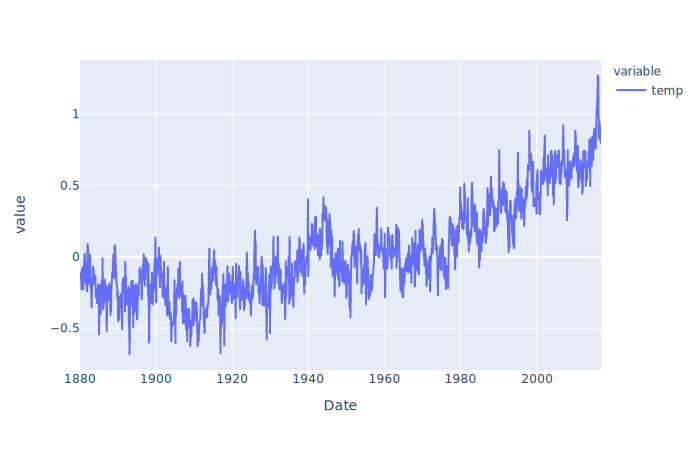

In [4]:
# we plot this quickly using plotly express library
px.line(temp, y=['temp'])

## Sunspots
Sunspots are temporary phenomena on the Sun's photosphere that appear as spots darker than the surrounding areas. They are regions of reduced surface temperature caused by concentrations of magnetic field flux that inhibit convection. Sunspots usually appear in pairs of opposite magnetic polarity. Their number varies according to the approximately 11-year solar cycle. **This dataset is a good example of seasonality in time series**

Source: https://en.wikipedia.org/wiki/Sunspot

In [5]:
sunspots = data.load_sunspots(frmt='pandas')

# parse dates and rename columns to something more convenient
sunspots['Date'] = pd.to_datetime(sunspots['Date'], format='%Y-%m-%d')
sunspots = sunspots.rename(columns={'Monthly Mean Total Sunspot Number': 'number'})
sunspots.head(5)

,Date,number
0,1749-01-31,96.7
1,1749-02-28,104.3
2,1749-03-31,116.7
3,1749-04-30,92.8
4,1749-05-31,141.7


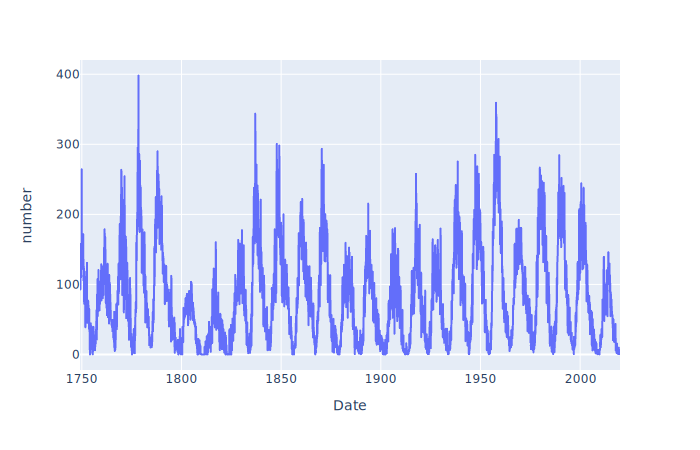

In [6]:
px.line(sunspots, x='Date', y='number')

## Weekly Sales

The data we are going to use is a weekly sales and price data for 9 stores and 3 products. I found this on a Medium Blog post by Susan Li. This dataset is a good example of how anomalies, like holidays show up in a time series.

Source: https://towardsdatascience.com/sales-forecasting-with-price-promotion-effects-b5d70207b128

In [7]:
sales_data = data.load_store_sales()
sales_data.head(2)

,Store,Product,Date,Is_Holiday,Base Price,Price,Weekly_Units_Sold
0,1,1,2/5/2010,False,9.99,7.99,245
1,1,1,2/12/2010,True,9.99,7.99,453


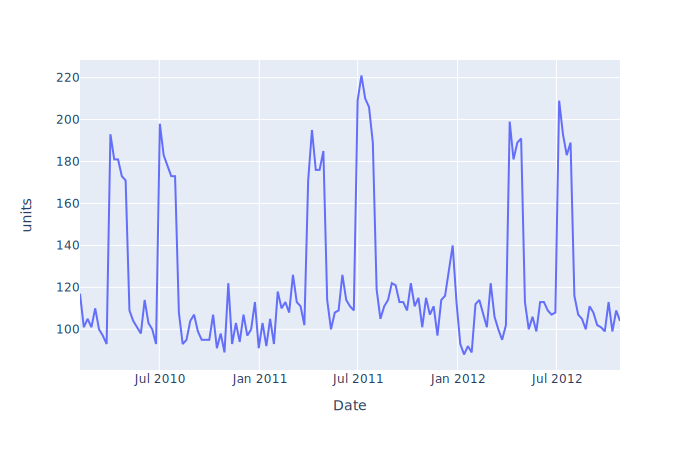

In [8]:
# we'll trim this down a bit, we'll just focus on one product and keep the date and units sold column
sales = (sales_data
         .query('Product == 2 and Store == 3 ')
         .filter(['Date', 'Weekly_Units_Sold'])
         .rename(columns={'Weekly_Units_Sold': 'units'})
        )

if sales['Date'].dtype == np.object:
    sales['Date'] = pd.to_datetime(sales['Date'], format="%m/%d/%Y").dt.date
    
px.line(sales, x='Date', y='units')

## White noise

Just in case, here is a white noise dataset.

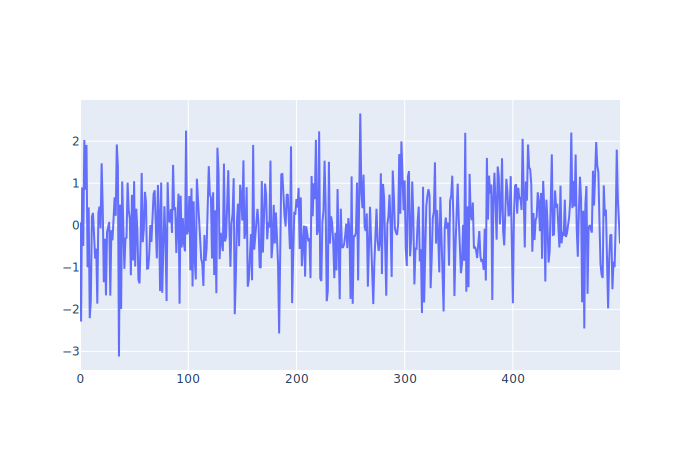

In [9]:
noise = np.random.normal(0, 1, 500)

viz.plot_basic_timeseries(noise)

# Time Series Decomposition (Trend, Seasonality, Cycles, Noise)

Wold's decomposition or the Wold representation theorem says that every **covariance-stationary** time series $ Y_{t}$ can be written as the sum of two time series, one deterministic and one stochastic

$X_t = V_t + S_t$

where $V_t$ is a linear deterministic process (i.e. a linear combination of lagged values with constant coefficients) and $S_t$ is an infinite moving average process of error terms $S_t = \sum_{i=0}^{\infty}\psi_i \eta_{t-i}$ where 

- the $\eta$s are linearly unpredictable white noise 
- $\psi_0=1$
- $\sum_{i=0}^{\infty}\psi_i < \infty$

Source: [Wikipedia](https://en.wikipedia.org/wiki/Wold%27s_theorem), [Topics in Mathematics with Applications in Finance](https://ocw.mit.edu/courses/mathematics/18-s096-topics-in-mathematics-with-applications-in-finance-fall-2013/video-lectures/)

This provides theoritical basis for time series decomposition. The idea is to develop a model that captures the deterministic component and learn the distribution of the noise so it can come up with a good foreacast for the time series. 

## The idea of auto-correlation

Auto means self. Auto-correlation is the correlation of a time series with its lagged self. If there is a trend in the series, then we should expect a point to be close to its previous and next neighbours. Therefore, you should see a correlation between a time series and its lagged self. Try this on white noise, and you get nothing

In [10]:
# You can compute auto-corr directly in pandas like this
temp['temp'].autocorr(lag=1)

0.9467067662403763

Correlation is reported on a scale of -1 to 1 (it's a normalized covariance). Here we see that monthly mean temperature time series has a strong auto-correlation with its 1 month lagged self. Makes sense, mean temperature is usually close to the mean temperature of previous month. We can play around with the lag and see how it the auto-corr changes

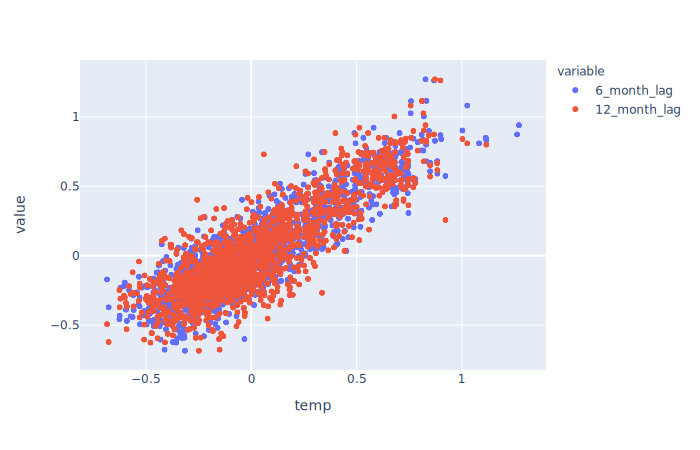

In [11]:
new_temp = temp.copy()
new_temp['6_month_lag'] = new_temp['temp'].shift(-6)
new_temp['12_month_lag'] = new_temp['temp'].shift(-12)

px.scatter(new_temp, x='temp', y=['6_month_lag', '12_month_lag'])

Now let's try on the whitenoise

In [12]:
df = pd.DataFrame(data=[])
df['noise'] = noise
df['lag_1'] = df['noise'].shift(1)
df['noise'].autocorr(1)

0.0357601312759533

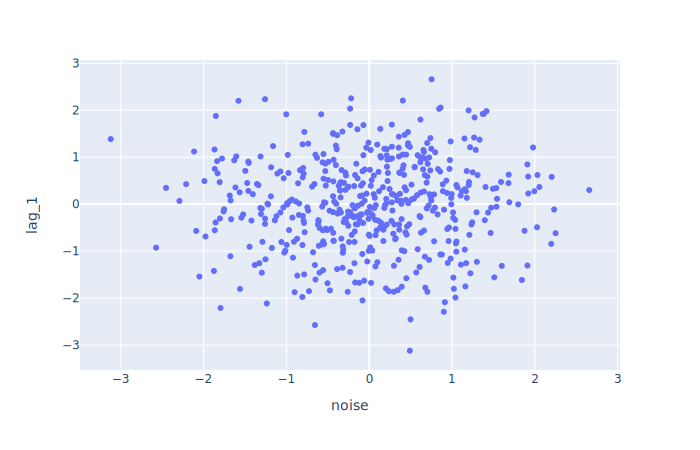

In [13]:
px.scatter(df, x='noise', y='lag_1')

as expected, no information whatsoever

## Auto Correlation Function (ACF)

The Auto Correlation Function (ACF), also known as the Correlogram, is a plot that shows different lag values and the corresponding correlation, for a given time series. statistical packages usually come with a function to plot acf. Here we will use the function provided by `statsmodels` under the `graphics` package

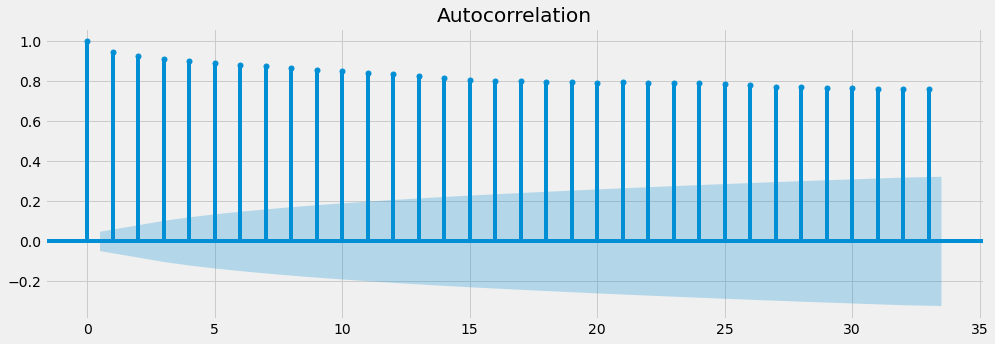

In [14]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(temp['temp']);

The auto-correlation persists even at 30+ lags. ACF usually show the level of significance of the correlation to indicate whether there is statistically signficant correlations (that's the blue band surrounding the x-axis)

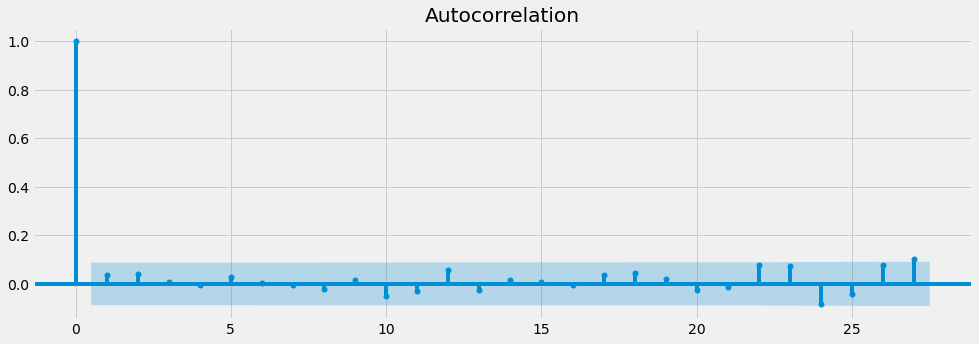

In [15]:
plot_acf(noise);

as you can see above, the ACF shows all spikes below the blue band, indicating non of these are statistically significant

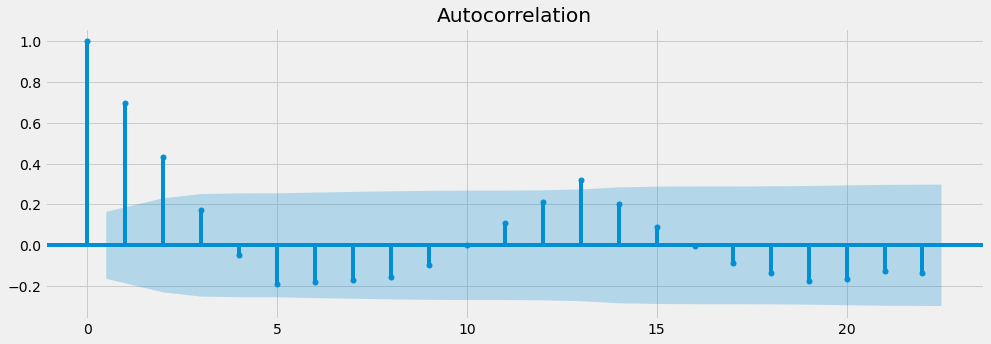

In [16]:
plot_acf(sales['units']);

The weekly sales dataset shows that the series correlates with itself with lag 1 and 2 weeks. There is also a barely significant spike around the 12th week, which might suggest something about a 12 weeks (three months) seasonality. It's not very strong though, but the 12 weeks number is interesting. What could it be? Maybe they give out promotions every quarter or something like that

## Partial Auto Correlation Function (PACF)

PACF is best explained using this excerpt from "Forecasting Principles and Practice" Book


Recall that an ACF plot shows the autocorrelations which measure the relationship between $y_t$ and $y_{t-k}$ for different values of k.Now if $y_t$ and $y_{t-1}$ are correlated, then $y_{t-1}$ and $y_{t-2}$ must also be correlated. However, then $y_t$ and $y_{t-2}$ might be correlated, simply because they are both connected to $y_{t-1}$ rather than because of any new information contained in $y_{t-2}$ that could be used in forecasting $y_{t}$

To overcome this problem, we can use partial autocorrelations. These measure the relationship between $y_t$ and $y_{t-k}$ after removing the effects of lags 1, 2, 3, ..., k-1. So the first partial autocorrelation is identical to the first autocorrelation, because there is nothing between them to remove. Each partial autocorrelation can be estimated as the last coefficient in an autoregressive model


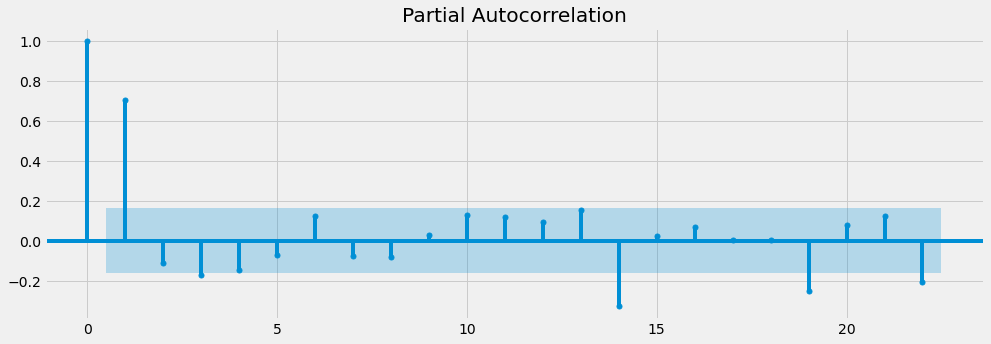

In [17]:
from statsmodels.graphics.tsaplots import plot_pacf

plot_pacf(sales['units']);

this is much better, doesn't give us false impressions about auto-corr beyond the second or maybe third lag.

## Seasonal and Trend decomposition using Loess (STL) Decomposition

A time series can be expressed as an additive model with three components

1. Trend
2. Seasonality
3. Noise (or residue)

The STL decomposition is a technique that uses LOESS Regression to compute these components. Once you decompose a time series into these components, and you believe the decomposition makes sense, then you can examine the residues for anomalies (for example, find residues that are 3 stddev from the mean)

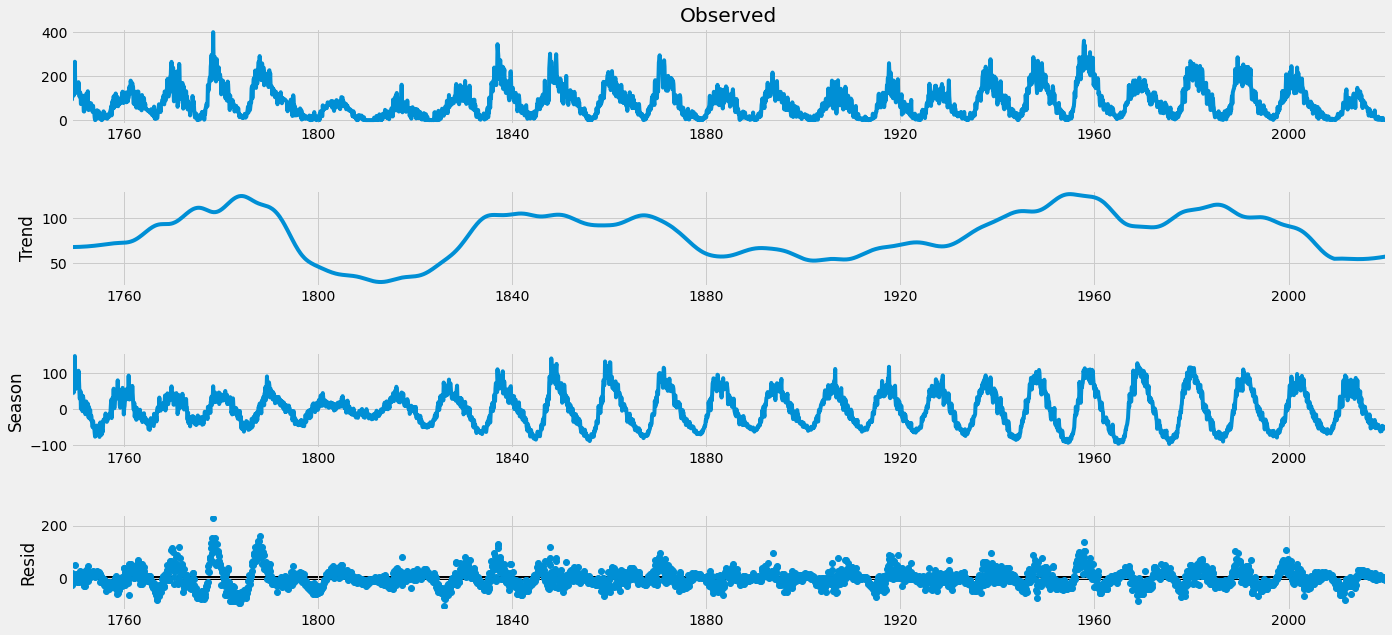

In [18]:
from statsmodels.tsa.seasonal import STL


stl = STL(sunspots.set_index('Date'), period=11*12+1) # 11 years cycle, so 11*12 months 
result = stl.fit()
fig = result.plot()

plt.gcf().set_size_inches(20, 10)

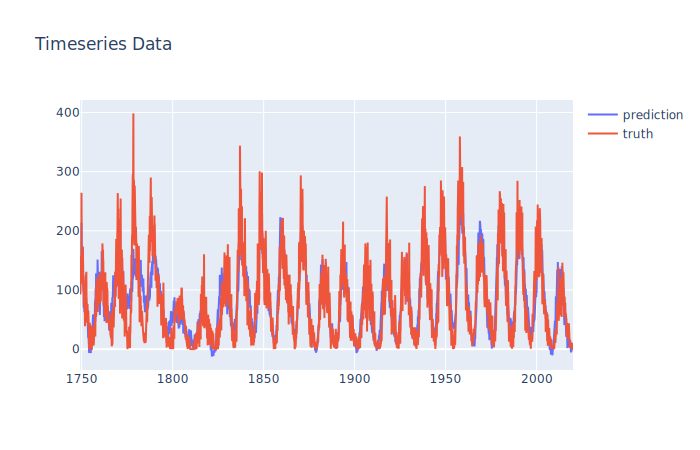

In [19]:
# to actually get the three components
trend, seasonal, resid = result.trend, result.seasonal, result.resid

# then you can add the trend and seasonal components to make a prediction
prediction = trend + seasonal
viz.plot_basic_timeseries(
    [prediction, sunspots.number], 
    index=sunspots.Date, 
    names=['prediction', 'truth']
)

Not bad! Looks like we can make pretty good descriptions (we'll discuss how to quanitfy the error in a couple of sections) with such a simple model. Notice that there is a period in the time series where the prediction is a bit off (mostly overestimating the truth). These could be anomalies.

Let's plot these outliers

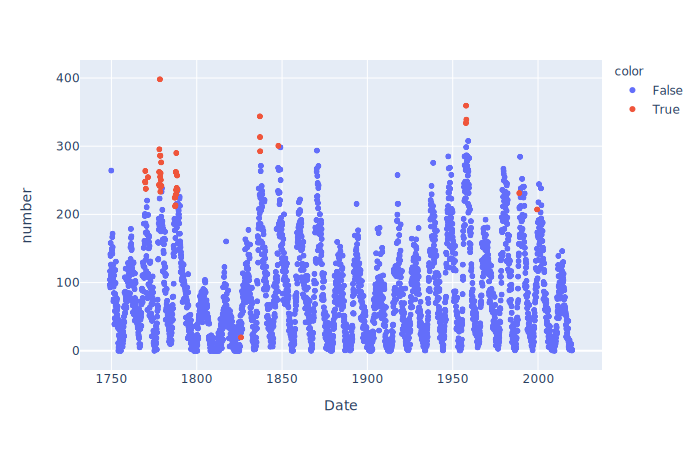

In [20]:
res_mean = resid.mean()
res_std = resid.std()

# outlier condition
nb_std = 3
outlier_cond = lambda x: (x >= res_mean + nb_std*res_std) or (x <= res_mean - nb_std*res_std)
outlier_mask = resid.apply(outlier_cond)

px.scatter(sunspots, x='Date', y='number', color=outlier_mask)

# Stationarity

from "Forecasting Principles and Practice" Book

*A stationary time series is one whose properties do not depend on the time at which the series is observed. Thus, time series with trends, or with seasonality, are not stationary — the trend and seasonality will affect the value of the time series at different times. On the other hand, a white noise series is stationary — it does not matter when you observe it, it should look much the same at any point in time.*

I also found this explanation by [Shay Palachy](https://towardsdatascience.com/stationarity-in-time-series-analysis-90c94f27322) to be rather insightful

*In the most intuitive sense, stationarity means that the statistical properties of a process generating a time series do not change over time. It does not mean that the series does not change over time, just that the way it changes does not itself change over time. The algebraic equivalent is thus a linear function, perhaps, and not a constant one; the value of a linear function changes as 𝒙 grows, but the way it changes remains constant — it has a constant slope; one value that captures that rate of change*

If you are interested in this topic, I recommend researching spurious regression and learning about how trying to build a regression model that predicts a non-stationary variable from another leads to all sort of problems.

In this section, I will use the global monthly temperature dataset as an example of a non-stationary dataset and attempt to stationarize.

## Mean Stationarity and Detrending

Differencing a time series removes changes in its level, and eliminates trends and seasonality.

- Taking the derivative (differencing is the discrete equivalent of differentiating) and can be applied multiple times
- Seasonal Differencing $ \hat{y_t} = y_t - y_{t+s} $

Note that if we can get a stationary series from a non-stationary series using the first difference, we call those series integrated of order 1 [see Yury Kashnitsky's kaggle notebook](https://www.kaggle.com/kashnitsky/topic-9-part-1-time-series-analysis-in-python)

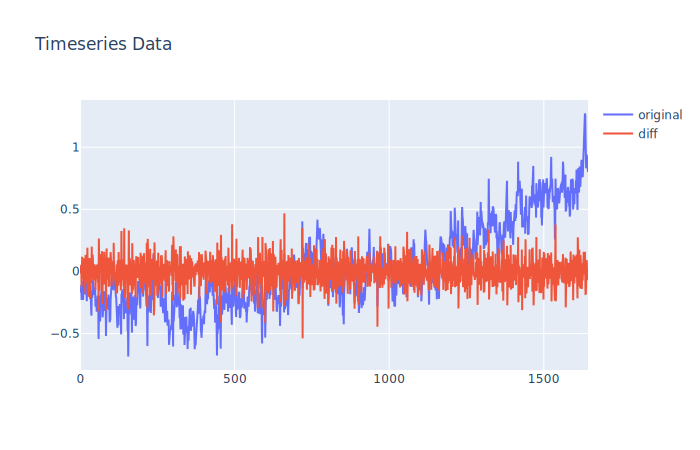

In [21]:
# simply taking the diff of the global temperature data removes the trend
viz.plot_basic_timeseries([temp.temp, temp.temp.diff()], names=['original', 'diff'])

How to reverse the diff operations? You can do this in numpy by using the first element in the time series that you diffed, then computing a cumulative sum.

In [22]:
s = np.random.normal(5, 2, 5) # some signal
d = np.diff(s) # diff the signal 
i = np.r_[s[0], d].cumsum() # concatenate signal's first element with the diff and then cumsum

print('Signal: ', s)
print('Signal diff: ', d)
print('Inverse Diff: ', i)

Signal:  [6.93312538 3.60819524 4.41386745 3.44668627 4.74970907]
Signal diff:  [-3.32493014  0.80567221 -0.96718118  1.30302279]
Inverse Diff:  [6.93312538 3.60819524 4.41386745 3.44668627 4.74970907]


## Variance Stationarity & Variance Stabilizing Transformations
The property of constant variance is known as homoscedasticity. If a time series is not homoscedastic then its variance depends on time. We can stabilize the variance using one of the following transformations

- Log transformation
- Box-Cox transformation (parameterized)


After making the forecast, we need to apply an inverse transform to go back to the original scale. I will create a synthetic dataset just to show this effect.

In [23]:
from scipy import stats

first_part = np.random.normal(10, 1, 100)
second_part = np.random.normal(10, 2, 100)
non_stationary_series = np.concatenate([first_part, second_part])
log_transformed = np.log(non_stationary_series)
box_cox_transformed = stats.boxcox(non_stationary_series)[0]

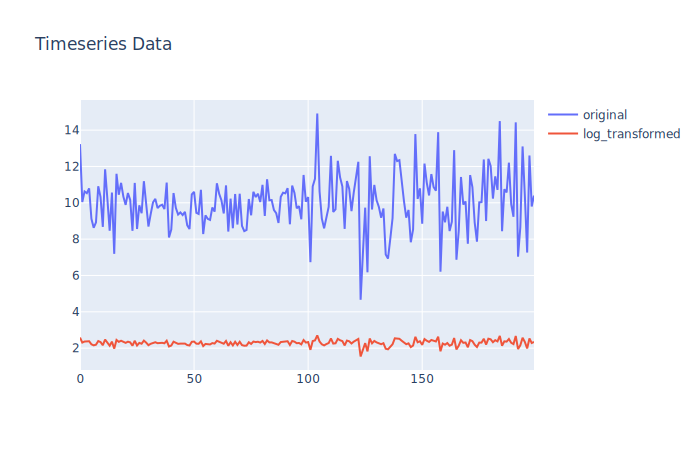

In [24]:
viz.plot_basic_timeseries([non_stationary_series, log_transformed], names=['original', 'log_transformed'])

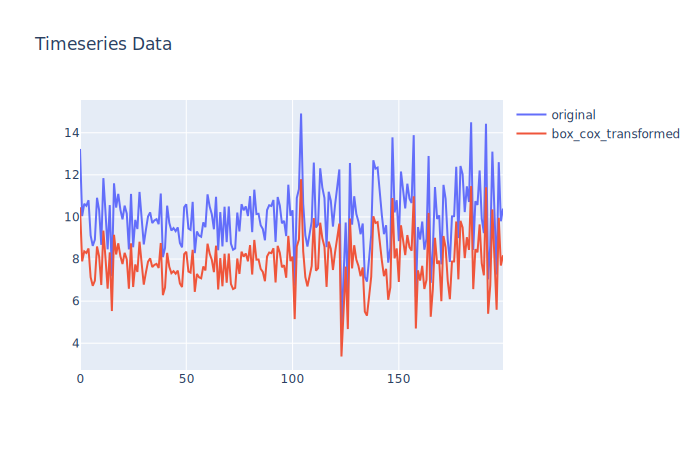

In [25]:
viz.plot_basic_timeseries(
    [non_stationary_series, box_cox_transformed], 
    names=['original', 'box_cox_transformed'])

## Covariance Stationarity

A sequence of random variables is covariance stationary if all the terms of the sequence have the same mean, and if the covariance between any two terms of the sequence depends only on the relative positions of the two terms, that is, on how far apart they are located from each other, and not on their absolute position, that is, on where they are located in the sequence. (source: statlect)

## Testing for non-stationarity

we can test the stationarity of a time series using the `Dickey–Fuller` test

In [26]:
from statsmodels.tsa.stattools import adfuller

**From statsmodels adfuller documentation**

The null hypothesis of the Augmented Dickey-Fuller is that there is a unit root, with the alternative that there is no unit root. If the pvalue is above a critical size, then we cannot reject that there is a unit root.

The p-values are obtained through regression surface approximation from MacKinnon 1994, but using the updated 2010 tables. If the p-value is close to significant, then the critical values should be used to judge whether to reject the null.

The autolag option and maxlag for it are described in Greene.

When the test statistic is lower than the critical value shown, you reject the null hypothesis and infer that the time series is stationary.

In [27]:
adf, p_value, usedlag, nobs, critical_values, _ = adfuller(non_stationary_series)
adf, critical_values, p_value

(-14.615145023080661,
 {'1%': -3.4636447617687436,
  '5%': -2.8761761179270766,
  '10%': -2.57457158581854},
 3.9652466228823e-27)

here, the adf is clearly much larger than the critical values, so the time series is non stationary, as we already know

In [28]:
stationarized_series = np.diff(stats.boxcox(non_stationary_series)[0], n=1)
adf, p_value, usedlag, nobs, critical_values, _ = adfuller(stationarized_series)
adf, critical_values, p_value

(-8.433255229782867,
 {'1%': -3.4654311561944873,
  '5%': -2.8769570530458792,
  '10%': -2.574988319755886},
 1.8456430064441816e-13)

In [29]:
adf, p_value, usedlag, nobs, critical_values, _ = adfuller(noise)
adf, critical_values, p_value

(-21.505616598627057,
 {'1%': -3.4435228622952065,
  '5%': -2.867349510566146,
  '10%': -2.569864247011056},
 0.0)

# Evaluating forecasts

Clearly, we need a quantative measure of how well a model is forecasting a time series. Simple visual inspection is tedious and unscalable. It can also be misleading. The most obvious choice is using the Root Mean Squared Error (RMSE) to judge the forecast.

## Foreacsting Metrics

sklearn implements most of the popular metrics for forecasting regression (and time series) probelms.

In [30]:
from sklearn.metrics import (
    r2_score, 
    median_absolute_error, 
    mean_absolute_error, 
    median_absolute_error, 
    mean_squared_error, 
    mean_squared_log_error
)

## Residuals Diagnostics
residuals in a time series model are what is left over after fitting a model. For many (but not all) time series models, the residuals are equal to the difference between the observations and the corresponding fitted values

Residuals must have these two properties:

- unbiasedness (mean zero) --> Wilcoxon Test
- uncorrelatdness (no auto-correlation)  --> Correlogram or Ljung-Box

The following two properties are nice to have but not necessary

- Normality --> qqplot or shapiro wilk test
- Stationary or constant variance  --> Visually or KPSS Test or Dickey-Fuller

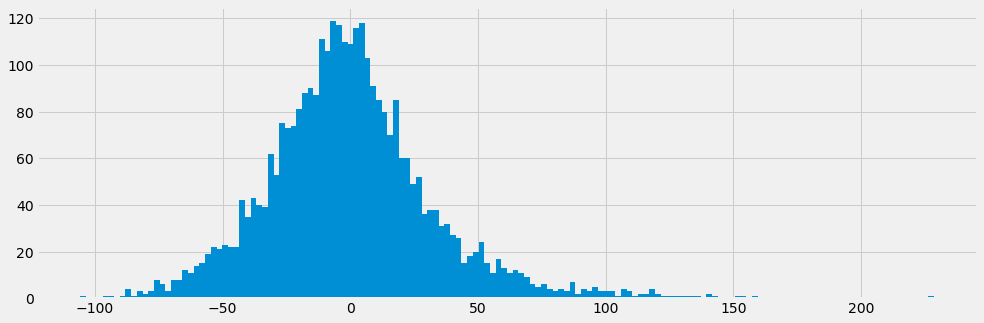

In [31]:
# we'll use the residuals from our simple sunspot mode
resid.hist(bins=150);

just from visual inspection, the residuals look normal. However, we want to ensure there is no bias in the distribution (i.e. the mean is zero). We test our hypothesis with the Wilcoxon Test

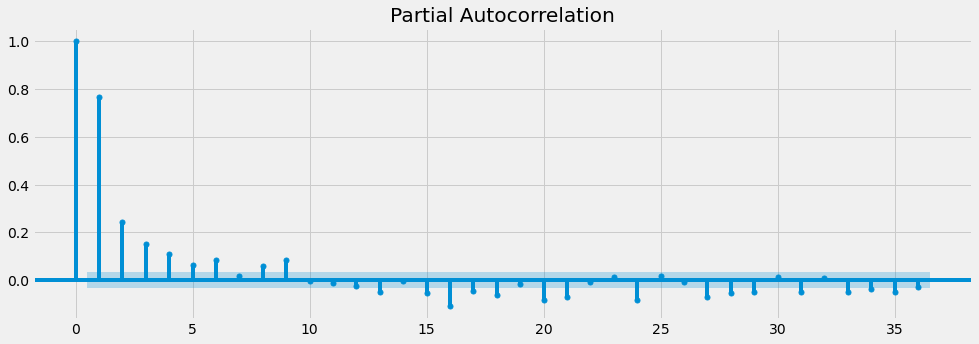

In [32]:
plot_pacf(resid);

the pacf shows clear auto-correlation of lags 1, 2 and maybe more for the residuals of the sunspots. It means out forecast did not capture all information and can be improved

25.064982661679593

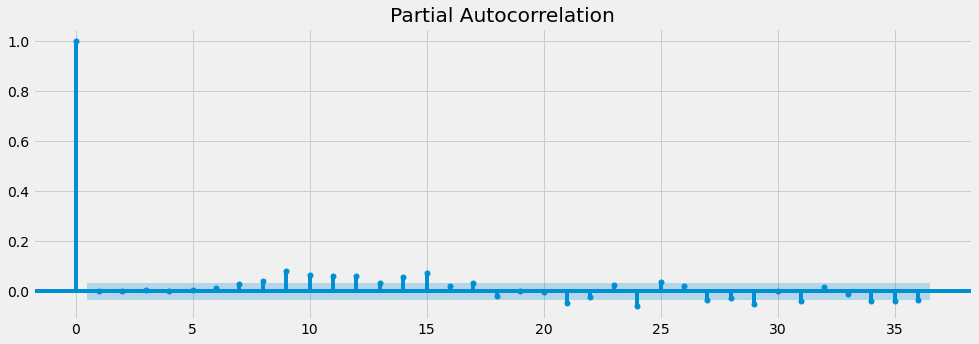

In [33]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error


def prep_data():
    # create features from lagged sunspot numbers
    sunspot_train = sunspots.copy()
    for lag in range(1, 10):
        sunspot_train[f'lag_{lag}'] = sunspot_train['number'].shift(lag)
    
    # our target is the number of sunspots
    sunspot_train = sunspot_train.rename(columns={'number': 'target'})
    sunspot_train = sunspot_train.dropna()

    # create the train dataset
    cols = [col for col in sunspot_train.columns if 'lag' in col]
    X_train = sunspot_train[cols]
    y_train = sunspot_train['target']
    
    return X_train, y_train
    

def train_and_predict(X_train, y_train):
    # train LR model
    lr = LinearRegression()
    lr.fit(X=X_train, y=y_train)

    # predict model (we're predicting on the train data on purpose, to overfit and get strong predictions)
    y_pred = lr.predict(X_train)
    
    return lr, y_pred


# run pipeline
X_train, y_train = prep_data()
model, y_pred = train_and_predict(X_train, y_train)

# compute residue
ml_residue = y_train - y_pred

plot_pacf(ml_residue);
mse = mean_squared_error(y_train, y_pred)
rmse = np.sqrt(mse)
rmse

In [34]:
# check the model coefficients to understand how the model is making predictions
model.coef_

array([ 0.57615614,  0.11205011,  0.09182262,  0.09531362,  0.0295316 ,
        0.05357119, -0.0272373 , -0.00215434,  0.03607273])

if we look at the linear regression coefficients, the model is using the past value (lag1) with a weight of 0.57 to make its prediction, then smaller combinations of the other lagged features

# ARIMA Models

ARIMA Models are a class of classical time series models that relies on the ideas of auto-regression and moving average to model trends and seasonality in any time series. They are widely succeful and for the most part, remain the state of the art in modelling and forecasting univariate time series with sparse data.

## AutoRegression (AR)

$ y_t = p*y_{t-1} + e_t$ AutoRegressive of order 1, or **AR(1)**

AR processes are stationary when the magnitude of the coefficients p are < 1 and $y_0$ has expectation of zero. Try to prove this yourself knowing that to show stationarity you need to look at the expected value, variance and covariance of some $y_t$ and $y_{t-h}$.

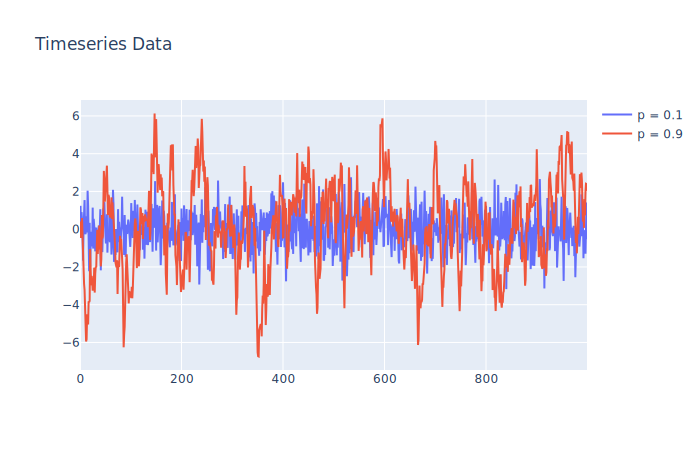

In [35]:
from typing import List

def make_ar(ps: List[float], drift: float=0.0)->list:
    """
    Generate an artificial autoregressive time series
    
    Arguments:
     ps: a list of weights, the number of the weights determines the order
     e.g. to generate y_t = p2 * yt-2 + p1 * yt-1 + e, supply the array [p2, p1] in this order
    
    Return
     ar: a list
    """
    order = len(ps)
    ar_ts = [0]*order
    for i in range(order, 1000):
        noise = np.random.normal(0, 1, 1)[0]
        regressions = sum([p * ar_ts[i-(j+1)] for j, p in enumerate(ps[::-1])])
        y_t = drift + regressions + noise
        ar_ts.append(y_t)
    return np.array(ar_ts)


# two AR(1) processes with different p. Low p shows a stationary noise-like signal that osciallates around the mean
# and never experience long runs of positive or negative, while high value of p takes us closer to non-stationarity
# with longer runs of positive and negative values. AR(1) becomes non-stationary when p = 1
p_low, p_high = 0.1, 0.9
ar_low_p = make_ar(ps=[p_low])
ar_high_p = make_ar(ps=[p_high])

viz.plot_basic_timeseries([ar_low_p, ar_high_p], names=[f'p = {p_low}', f'p = {p_high}'])

AR(1) processes with p=1 are known as random walks. They are non-stationary processes. Random walk models are widely used for non-stationary data, particularly financial and economic data. Random walks typically have:

- long periods of apparent trends up or down
- sudden and unpredictable changes in direction

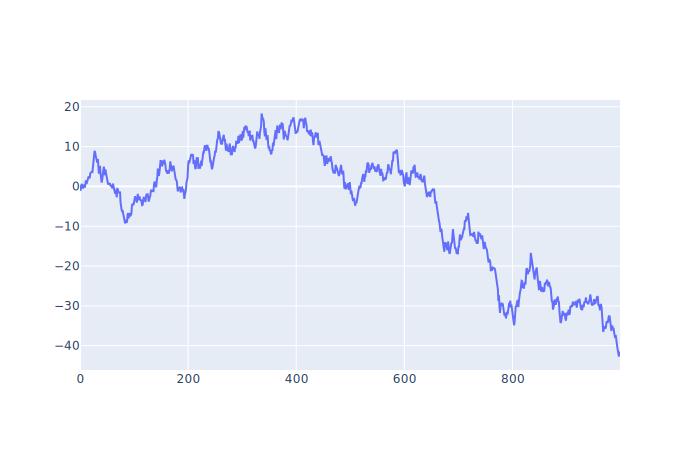

In [36]:
random_walk = make_ar([1])
viz.plot_basic_timeseries(random_walk)

You can also have a random walk with a drift if you add a constant to the right hand side of the equation

$y_t = \alpha + y_{t-1} + \epsilon_t$

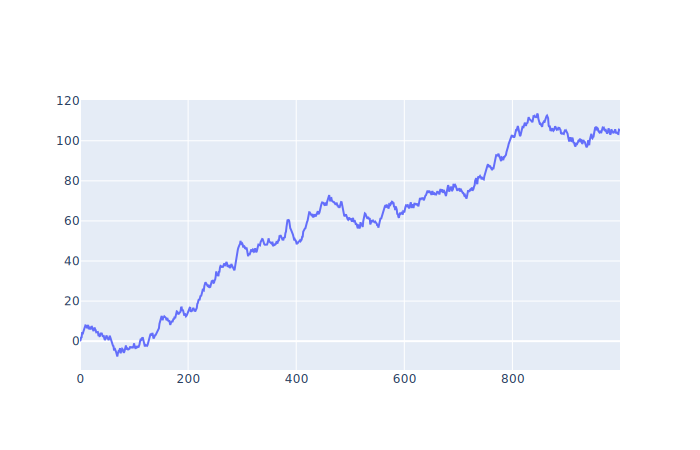

In [37]:
random_walk_with_drift = make_ar([1], drift=0.05)
viz.plot_basic_timeseries(random_walk_with_drift)

The ACF here shows how the AR process is weekly dependent, with the auto-regression decaying over time

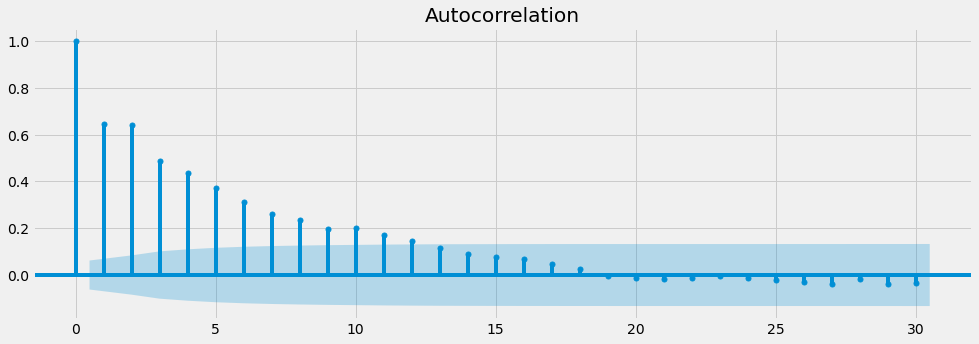

In [38]:
ar_order_2 = make_ar(ps=[0.4, 0.4])
plot_acf(ar_order_2);

The PACF shows the relationship between $y_t$ and $y_{t-k}$ after removing the effects of lags 1, 2, 3, ..., k-1. Here it shows that the AR process we generated is of order 2

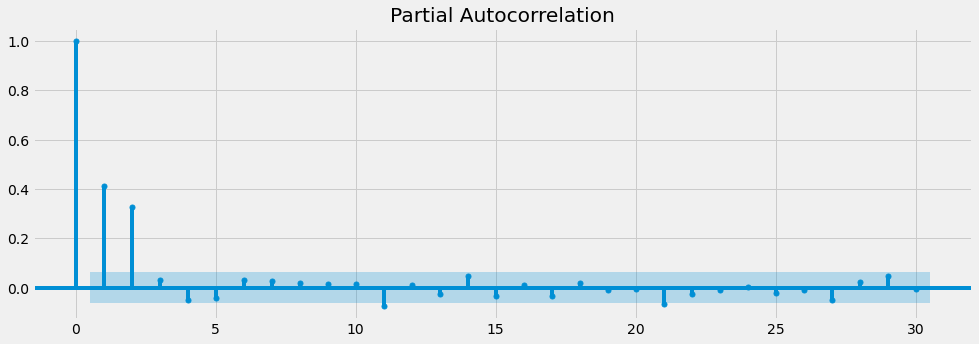

In [39]:
ar_order_2 = make_ar(ps=[0.3, 0.3])
plot_pacf(ar_order_2);

## Moving Average (MA)

$y_t = \theta_1 * \epsilon_{t-1} + \epsilon_t$ is a moving average process with order 1, or **MA(q=1)**


$y_t = \theta_2 * \epsilon_{t-2} + \theta_1 * \epsilon_{t-1} + \epsilon_t$ **MA(q=2)**

where the epsilons are iid ~ $N(0, \sigma^2)$

Moving average processes are stationary and weakly depndent ($y_t$ is dependent on noise from few time steps before, but eventually this effect goes away, so you can think of $y_t$ as locally depndent but globally independent)

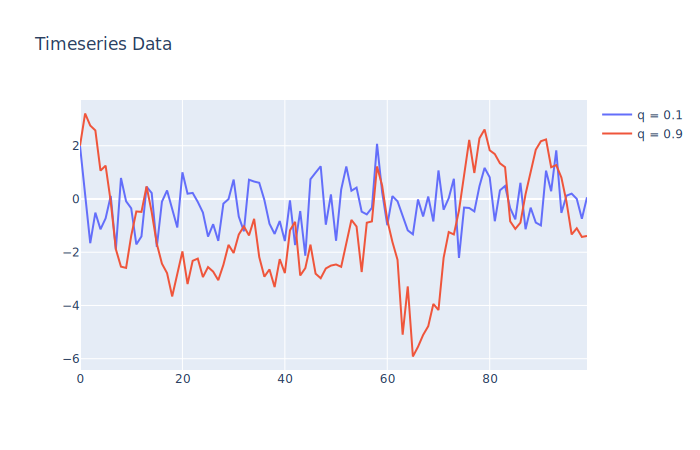

In [40]:
def make_ma(qs):
    """
    Generate an artificial moving average time series
    
    Arguments:
     qs: a list of weights, the number of the weights determines the order
     e.g. to generate y_t = q2 * e_t-2 + q1 * e_t-1 + e_t, supply the array [q2, q1] in this order
    
    Return
     ar: a list
    """
    order = len(qs)
    ma_ts = [2]*order
    for i in range(order, 100):
        noise = np.random.normal(0, 1, 1)[0]
        regressions = sum([q * ma_ts[i-(j+1)] for j, q in enumerate(qs[::-1])])
        y_t = regressions + noise
        ma_ts.append(y_t)
    return np.array(ma_ts)
   
low_q, high_q = 0.1, 0.9
ma_low_q = make_ma([low_q])
ma_high_q = make_ma([high_q])

viz.plot_basic_timeseries([ma_low_q, ma_high_q], names=[f'q = {low_q}', f'q = {high_q}'])

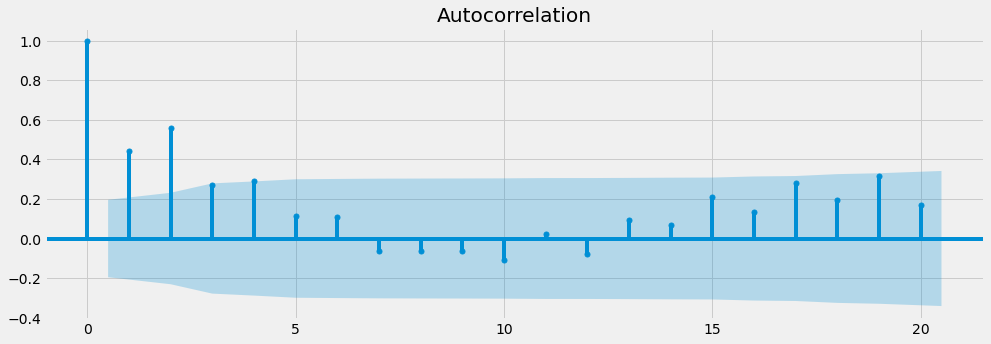

In [41]:
ma_example = make_ma([0.4, 0.4])
plot_acf(ma_example);

note how the ACF decays faster for MA processes than it does for AR processes. MA processes have less of a memory than their AR counterparts

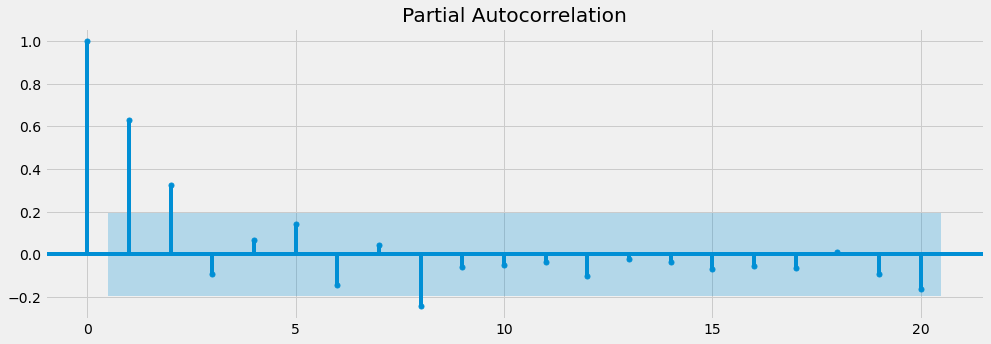

In [42]:
ma_example = make_ma([0.4, 0.4])
plot_pacf(ma_example);

## ARMA  - ARIMA - SARIMA

The ARMA Model adds an AR(p) process to an MA(q) process to model a time series. ARIMA is an expansion of ARMA where we indicate the number of times we diff'ed the series (d). So ARIMA models are characterized by parameters (p,q,d).

SARIMA models are equivalent to ARIMA except they also model the seasonal component by adding the parameters

- P: Seasonal autoregressive order
- D: Seasonal difference order
- Q: Seasonal moving average order

A SARIMA model therefore is characterized by the set of parameters (p, q, d) x (P, Q, D).

Here is an example of how seasonal differencing works

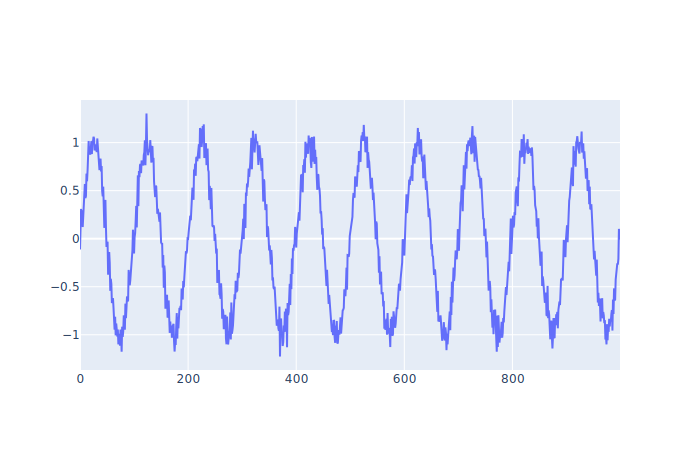

In [43]:
# import this helpful function from the dsp module
from ts.dsp import make_sinusoidal_signal

# make a sin wave with some noise, 100 points per cycle, and repeat it 10 cycles
sin_signal = make_sinusoidal_signal(points=100, freq=10)

# visualize
viz.plot_basic_timeseries(sin_signal)

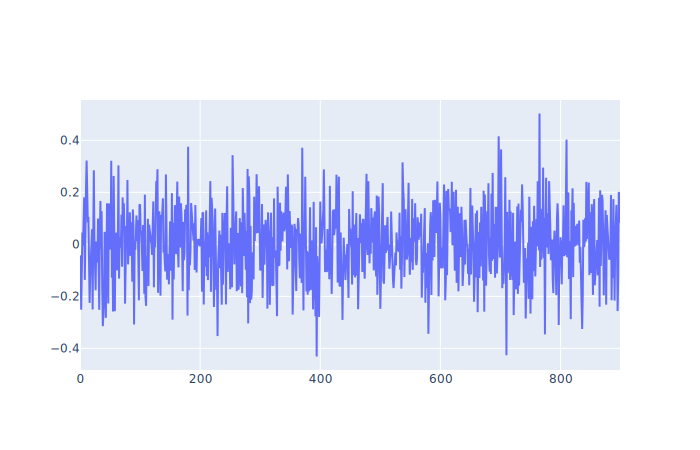

In [44]:
# implement a seasonal diff function
def seasonal_diff(data, nb_points_per_cycle: int):
    diff = []
    for i in range(nb_points_per_cycle, len(data)):
        diffed_point = data[i] - data[i-nb_points_per_cycle]
        diff.append(diffed_point)
    return np.array(diff)

seasonally_diffed = seasonal_diff(sin_signal, 100)
viz.plot_basic_timeseries(seasonally_diffed)

as you can see, the signal is pretty much white noise now. The seasonal aspect is completely removed. If you pass a different frequency (e.g. 95 instead of a 100) to the seasonal_diff function, you'll see remnants of the signal. in practice, you don't have to implement this funciton yourself, it is available in pandas

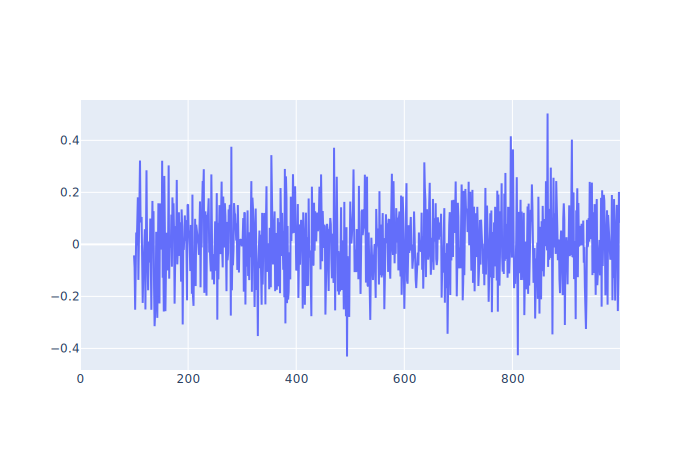

In [45]:
seasonally_diffed = pd.Series(sin_signal).diff(periods=100)
viz.plot_basic_timeseries(seasonally_diffed)

# Fitting ARIMA Models

In this section, we will see how to fit a SARIMA model to some of our datasets. The key thing here is to learn how to estimate the range of hyper-parameters (p, d, q) x (P, D, Q) from the preprocessing steps applied to the time series and the ACF and PACF plots.

## Predicting Monthly Global Temperatures

Here is a little case study, let's use the global temperature data to fit a SARIMAX model and see how well it forecasts temperatures in the last two years of our dataset. First we need to split the train and test data

In [46]:
temp.head(2).append(temp.tail(2))

,temp
Date,
1880-01,-0.14955
1880-02,-0.16645
2016-11,0.84020
2016-12,0.79975


In [47]:
split_date = '2015-01'
train_data, test_data = temp.query(f'Date < "{split_date}"'), temp.query(f'Date >= "{split_date}"')
print('Length of train data:', len(train_data))
print('Length of test data:', len(test_data))

Length of train data: 1620
Length of test data: 24


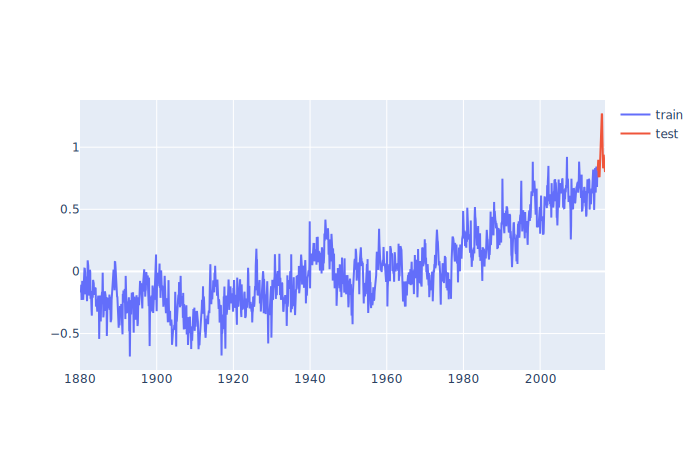

In [48]:
# use the sales dataset
data = [train_data.temp, test_data.temp]
indices = [train_data.index, test_data.index]
names = ['train', 'test']
viz.plot_train_test(data, indices, names)

This is obviously a non-stationary time series. Non-Stationarity is coming from the seasonal trend, so let's get rid of that using the pandas diff functions with period = 11 * 12 (the sunspots cylce occurs every 11 years, and our data is monthly)

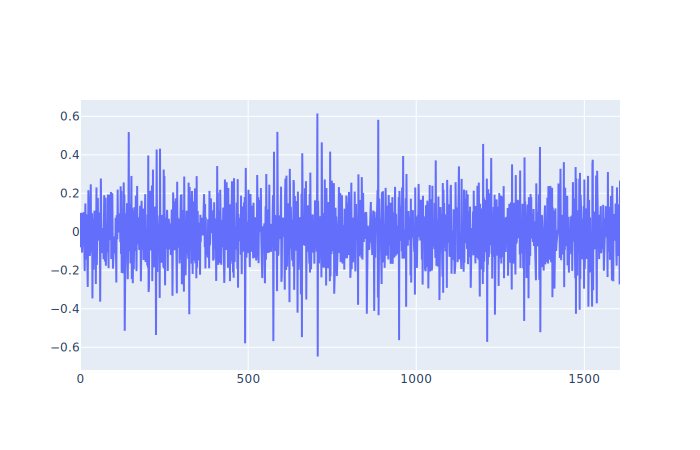

In [49]:
train_data_diff = train_data.temp.diff(periods=12).diff(periods=1).dropna()
viz.plot_basic_timeseries(train_data_diff)

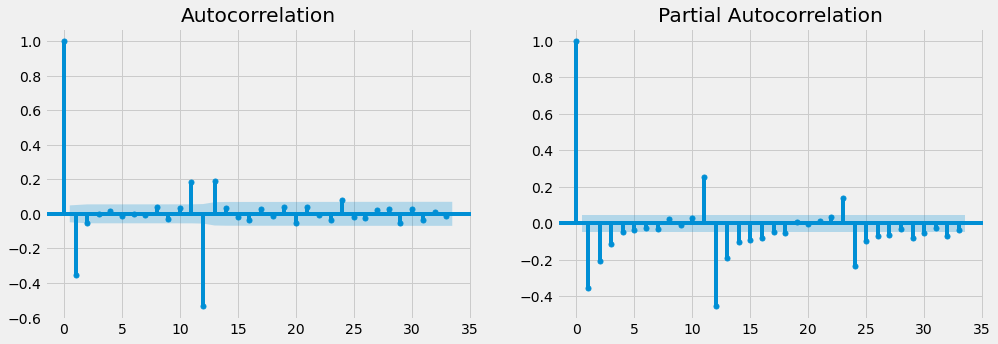

In [50]:
viz.plot_acf_pacf(train_data_diff)

Note: SARIMAX is unfortunately not fast for models with large seasonal orders (see [this](https://github.com/statsmodels/statsmodels/issues/6033))

In [51]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

p = 3
q = 2
d = 1

P = 2
Q = 1
D = 1

s = 12

order=(p, d, q)
seasonal_order = (P, D, Q, s)
model= SARIMAX(train_data_diff, order=order, seasonal_order=seasonal_order)
fitted_model = model.fit(simple_differencing = True)
fitted_model.summary()

/Users/mohamed/Desktop/projects/timeseries/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/Users/mohamed/Desktop/projects/timeseries/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/Users/mohamed/Desktop/projects/timeseries/venv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                 temp   No. Observations:                 1607
Model:             SARIMAX(3, 1, 2)x(2, 1, [1], 12)   Log Likelihood                1168.787
Date:                              Tue, 06 Oct 2020   AIC                          -2319.573
Time:                                      21:39:30   BIC                          -2271.207
Sample:                                  02-01-1881   HQIC                         -2301.610
                                       - 12-01-2014                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.3670      0.294     -4.649      0.000      -1.943      -0.791
ar.L2         -0.6046      0.129     -4.672      0.000      -0.858      -0.351
ar.L3         -0.1887      0.054     -3.492      0.000      -0.295      -0.083
ma.L1         -0.0676      0.293     -0.231      0.817      -0.641       0.506
ma.L2         -0.9306      0.301     -3.088      0.002      -1.521      -0.340
ar.S.L12      -0.6886      0.021    -32.193      0.000      -0.731      -0.647
ar.S.L24      -0.2898      0.023    -12.866      0.000      -0.334      -0.246
ma.S.L12      -0.9964      0.108     -9.208      0.000      -1.209      -0.784
sigma2         0.0128      0.002      8.055      0.000       0.010       0.016
===================================================================================
Ljung-Box (L1) (Q):                   1.40   Jarque-Bera (JB):                55.99
Prob(Q):                              0.24   Prob(JB):                         0.00
Heteroskedasticity (H):               0.86   Skew:                            -0.07
Prob(H) (two-sided):                  0.09   Kurtosis:                         3.91
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

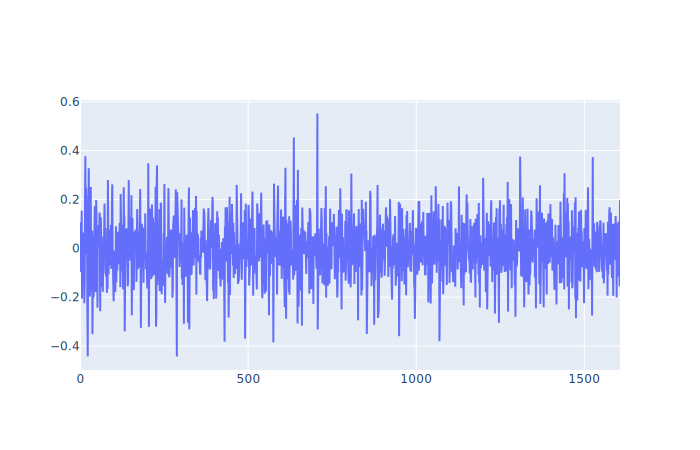

In [52]:
viz.plot_basic_timeseries(fitted_model.resid)

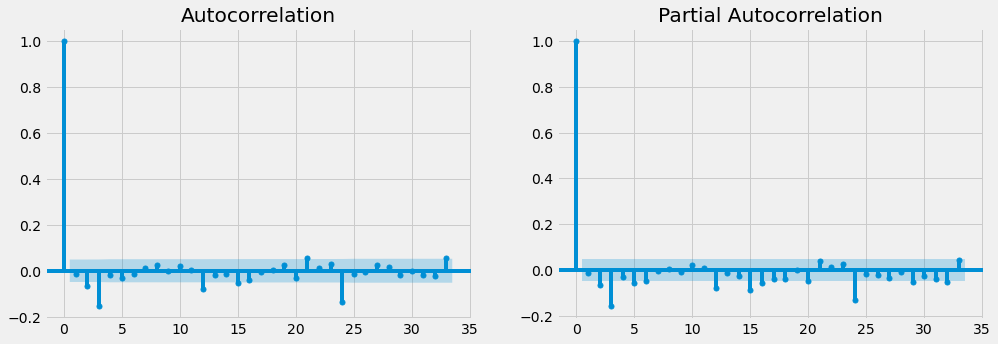

In [53]:
# now let's plot the model residues and make sure they are not correlated
viz.plot_acf_pacf(fitted_model.resid)

could be better, but not bad

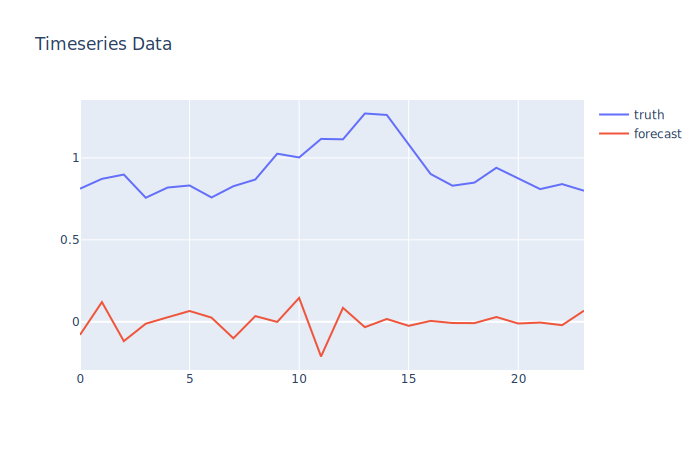

In [54]:
forecast = fitted_model.forecast(len(test_data))
viz.plot_basic_timeseries([test_data.temp, forecast], names=['truth', 'forecast'] )

In [55]:
rmse = np.sqrt(mean_squared_error(test_data.temp, forecast))
print(f'RMSE of the SARIMAX forecast is {rmse:.2f}')

RMSE of the SARIMAX forecast is 0.94


We can do better with a **Rolling Forecast Origin** approach, where we predict one month in advance and then use the true value to retrain the model and make the next month's prediction

## Akaike Information Criterion (AIC)

a substitute for cross validation. Balances between number of parameters (model complexity) and performance (i.e. regularizer)

Can we consider AIC as a form of regularization?
```
It can indeed be interpreted as a type of regularization, but it is not similar to lasso or ridge regression. The latter two regularize by penalizing nonzero values of the parameter estimates as part of the estimation procedure, whereas AIC, in effect, penalizes the number of parameters included in the model - which is typically specified by the modeler, not internally to the estimation procedure (with exceptions for certain automated model selection procedures such as stepwise regression.)

AIC is intended to facilitate comparisons between models, and the coefficient of 2 multiplying the 𝑘 is derived from asymptotic considerations. I agree the additive "4" is not useful and can be removed. However, given the derivation, it's clear that the factor of "2" should remain - it makes the penalty for adding parameters to the model twice as large as otherwise, so it really isn't the same as a penalty of just 𝑘, and does have some asymptotic optimality properties.
```

Source:

- jbowman (https://stats.stackexchange.com/users/7555/jbowman), Does Akaike's Information Criterion correspond to a type of regularization?, URL (version: 2017-12-15): https://stats.stackexchange.com/q/319054

## ARIMA Hyper-parameter Tuning

In [57]:
from itertools import product                    # some useful functions

# setting initial values and some bounds for them
ps = range(2, 5)
d=1 
qs = range(2, 5)
Ps = range(0, 2)
D=1 
Qs = range(0, 2)
s = 24 # season length is still 24

# creating list with all the possible combinations of parameters
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

36

# ARIMA Forecasting Framework 

1. Plot the time series and observe patterns, seasonality, etc.
2. Transform the time series to stabilize the variance if needed
3. Decide on the order of differencing (d) and seasonal differencing (D)
4. Plot the ACF/PACF of the time series and use these plots to guess initial values for Hyper-parameters p,q,P,Q
5. Fit the models and compare their AIC Values, then select the winning combination of hyper-parameters
6. Check residuals to make sure our model is not missing any information

# Anomalies (e.g. Holidays) and SARIMAX

# Limitations and Practicality

Classical time series models such as ARIMA, SARIMA, etc. are theoritically well founded and therefore tend to perform well on univariate time series forecasting problems. However, due to the difficulties of estimating hyper-parameters, and the fact that we have to manually perform visual inspection of ACF/PACF, and check residuals, etc. they can be cumbersome if we have a large volume of data.

Modern Machine Learning approaches, those that depend on transforming time series forecasting problems to supervised learning problems, lend themselves better to multivariate time series problems, and univariate time series problems with large amount of data (>100 points).